# 09.07 Model Persistence

It takes a moment to train a model,
moreover since that normally mean training several models and preforming model selection.
The reason to train a model is for it to be useful against real problems.
Often we want to use the model against data that we do not have whilst we are training it.
Therefore we want to save the trained model for later reuse.

![Bow Tie](sl-bow-tie.svg)

<div style="text-align:right;"><sup>sl-bow-tie.svg</sup></div>

In Python we can simply use `pickle` to dump a model to a file.
Yet, `pickle` is particularly ineffective and slow at serializing NumPy arrays.
A better option is `joblib` which uses NumPy's internal memory mappings
(memory mapped files on systems that support it) or stream compression
to reduce the size of the file,
the time to load it from disk and even the size of the model in memory.
`joblib` has a `pickle` interface and we can use the below to deal with
systems that may or may not have `joblib` installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
try:
    from joblib import dump, load
except ImportError:
    from pickle import dump, load

Let's create some regression data and make a Random Forest Regression on top of it.
We build a *bow tie toy dataset*.

In two dimensions we order random points in order to make their
coordinates to be close to the main diagonal of the plane.
Then we create a function in the third dimension which will increase
into both the negative and positive sides as it walks away from the origin.
Since we only feed points close to the plane's diagonal we end
with a bow tie structure.

In [2]:
n_points = 1024
X = np.sort(200 * np.random.rand(n_points, 2) - 100, axis=0)
y = np.array(np.pi*X[:, 0] * np.sin(X[:, 1])) + 0.5 - np.random.rand(n_points)
X.shape, y.shape

((1024, 2), (1024,))

We can plot the dataset in three dimensions to check it.

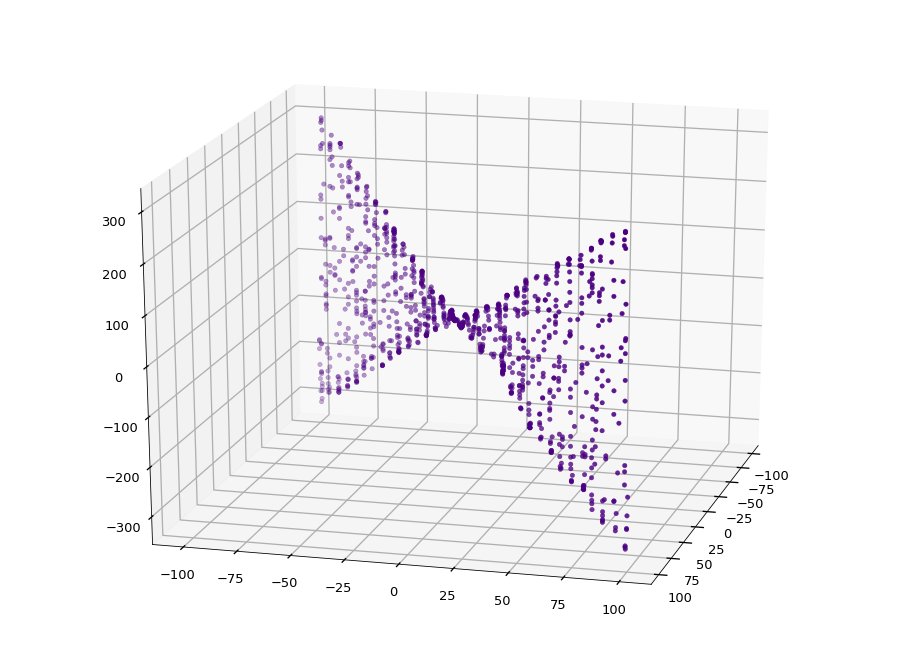

In [3]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, color='indigo')
ax.view_init(elev=20., azim=15);

The random forest has a hyperparameter that we will tune using a grid search,
the number of trees used for the regression.
We will use cross validation to determine this hyperparameter.
We are quite familiar with the ideas by this point.

Before performing the grid search and the cross validation we will split
the data into training and test sets.
Then we run cross validation on the training set only.

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
grid = GridSearchCV(RandomForestRegressor(),
                    {'n_estimators': [10, 20, 50, 100, 200]},
                    cv=KFold(n_splits=5, shuffle=True))
grid.fit(X_train, y_train)
grid.best_score_, grid.best_estimator_

(0.9518904083571794,
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False))

That's a reasonable score.

And let's see if we are not overestimating the generalization of this model.
We can do this since we did keep a test set on the side until now.

In [5]:
model = grid.best_estimator_
model.score(X_test, y_test)

0.9676999709860159

The real generalization estimate is somewhere in between,
closer to the lowest value.

Let's have a quick visual check as well, since this model does not have too many dimensions.

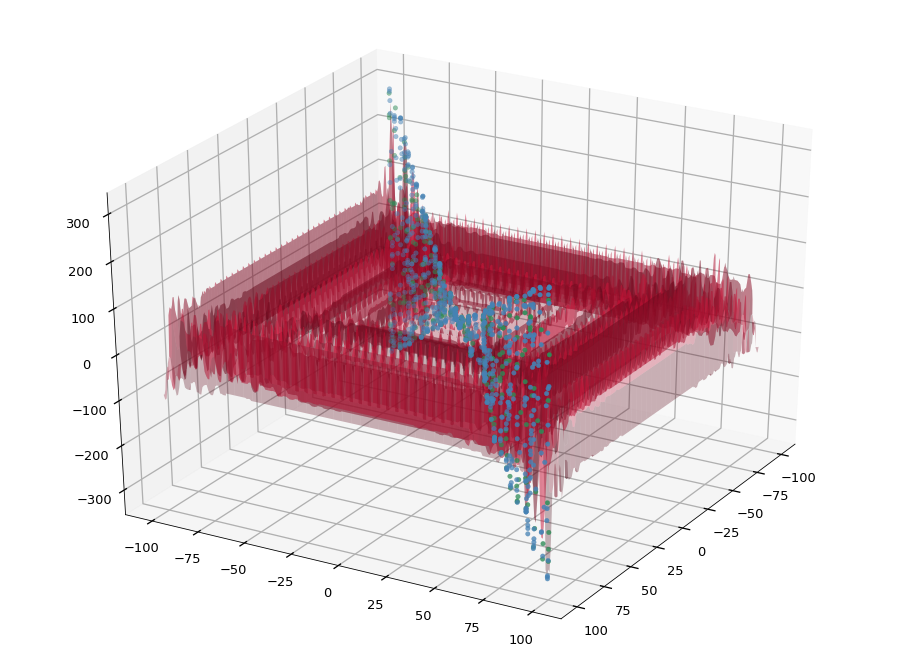

In [6]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='steelblue')
ax.scatter(X_test[:, 0], X_test[:, 1], y_test, color='seagreen')

n_points = 256
pred_pi = np.linspace(-100, 100, n_points)
pred_sin = np.linspace(-100, 100, n_points)
gpi, gsin = np.meshgrid(pred_pi, pred_sin)
X_pred = np.c_[gpi.ravel(), gsin.ravel()]
y_pred = model.predict(X_pred)
ax.plot_surface(gpi, gsin, y_pred.reshape(n_points, n_points), alpha=0.3, color='crimson')
ax.view_init(elev=30., azim=30);

The Random Forest makes a model for the whole space
but what we really care about is that it makes the correct model
for the space close to the dataset itself.

This model is good for our purposes because we know
that we are expecting a bow tie.
We expect small values in the middle and bigger values away from the origin.
And, since we are confident about this model, we should save it.

In [7]:
with open('rfr.pickle', 'wb') as f:
    dump(model, f)

This just created a file called `rfr.pickle` in the current directory.
The file is a binary (pickled) representation of the model (object) we juts used.
We can read it back now into a different variable.

In [8]:
with open('rfr.pickle', 'rb') as f:
    rfr = load(f)

And we can check if the model loaded back from this file is the same one.

In [9]:
rfr.score(X_test, y_test)

0.9676999709860159

This is exactly the same test score ($R2$) as before,
we can be quite confident that we got the same model back.

## Caveats

The interoperability between different versions of Python's `pickle` module is poor.
In other words, exchanging models between Python 2 and Python 3 projects
through `pickle` is a very bad idea.
Python 2 reached its end of life but many places still use it.

More advanced uses of `joblib`, e.g. gzipped files, do not keep full compatibility to `pickle`.
It isn't anything that cannot be worked around by uncompressing a file before *unpickling*
but one needs to be consistent on how to treat persisted models.
Pickled files contain very little metadata on how to load them back.

## `joblib`

Is much more extensive than just persisting models.
The main aim of the library is to automate several processes in a machine learning
pipeline by memoizing intermediate results to disk, as extended pickle.
Two things that the library specializes are:

- Memoize results of huge computations on disk,
  so one does not necessarily need to re-run the entire processing if something goes wrong.

- Memory map NumPy arrays during parallel processing,
  allowing separate processes to share memory and preventing copying huge arrays between processes.

For training big models on a single machine, `joblib` helps a good deal.
A process of memoization is a technique of saving intermediate results
of processing in order to not need to perform the computation again.
Algorithms often perform the same computation over and over,
in which case memoization can have a considerable impact on performance.

## Should I always persist my model?

Not necessarily.
An ML model will wander off course over time,
i.e. the real world will change in a way that the model do not reflect it anymore.
Often one needs to retrain a model periodically for it to be useful.
One would collect the data that is thrown at the model and construct a new training
set by mixing the new data with the old training set.

A case where retraining a model often makes sense are web services.
A web service will run several models of the same kind, and will predict values for user requests.
The service runs several models for load balancing,
i.e. even when one of the machines goes down the service can still respond to users.
These machines run non-stop but sometimes need to be taken down for maintenance:
a machine is taken down, updated, restarted, tested and only then placed back into the load balancing.
Since the machine restart may take a while,
re-training the model that is part of the service during this restart is a good idea.
Such re-trained model knows about new training data and will be (hopefully) better.